<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Week%206/Google%20Colab/Tugas_Week_6_Tensorflow_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Embedding, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import keras_tuner as kt

# Preprocessing Data

In [ ]:
data = pd.read_json('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json', lines=True)

In [ ]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ==== Hyperparameter ====
epochs = 10
num_words = 15000
maxlen = 200
batch_size = 256
embed_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15

In [ ]:
# ==== Tentukan kolom yang digunakan ====
review_col = 'headline'
rating_col = 'is_sarcastic'

# ==== Cek dan isi NaN ====
data[review_col] = data[review_col].fillna("").astype(str)

# ==== Preprocessing Teks ====
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)     # Hapus tanda baca
        text = re.sub(r'\d+', '', text)         # Hapus angka
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        return ' '.join([w for w in words if w not in stop_words])
    else:
        return ""

data['processed_review'] = data[review_col].apply(preprocess_text)

In [ ]:
# ==== Labeling ====
rating_threshold = 3
data['sentiment'] = (data[rating_col] > rating_threshold).astype(int)

# ==== Buat Vocabulary ====
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(max_words - 1))}
    vocab[''] = 0
    return vocab

vocabulary = build_vocab(data['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15000


In [ ]:
# ==== Convert teks ke sequence ====
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # 0 untuk OOV dan padding
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    else:
        return sequence + [0] * (maxlen - len(sequence))

data['sequence'] = data['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

In [ ]:
data.head()

,article_link,headline,is_sarcastic,processed_review,sentiment,sequence
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret black c...,0,"[198, 14272, 676, 3386, 2098, 261, 33, 1996, 2..."
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catches thorny political mood...,0,"[8017, 3123, 2531, 8018, 289, 2719, 154, 828, ..."
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear sons web series closest thin...,0,"[68, 696, 677, 970, 1903, 461, 4447, 115, 1021..."
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner wants wife listen come alternative deb...,0,"[1331, 124, 317, 1513, 210, 3124, 14273, 739, ..."
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday magical...,0,"[4448, 4449, 766, 10219, 462, 442, 1117, 32, 0..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_link      26709 non-null  object
 1   headline          26709 non-null  object
 2   is_sarcastic      26709 non-null  int64 
 3   processed_review  26709 non-null  object
 4   sentiment         26709 non-null  int64 
 5   sequence          26709 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [ ]:
# ==== Split Dataset ====
X = np.array(data['sequence'].tolist())
y = np.array(data['sentiment'].tolist())

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
Counter(y)

Counter({np.int64(0): 26709})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN Model

In [ ]:
def model_builder(hp):
    model = Sequential()

    # Hyperparameter untuk embedding dimensi
    embed_dim = hp.Choice('embed_dim', values=[32, 64, 128])
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False))

    # Hyperparameter untuk jumlah layer RNN
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    hidden_dim = hp.Choice('hidden_dim', values=[64, 128, 256])

    for i in range(num_layers - 1):
        model.add(SimpleRNN(units=hidden_dim,
                            return_sequences=True,
                            dropout=0.3,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))

    # Layer RNN terakhir
    model.add(SimpleRNN(units=hidden_dim,
                        return_sequences=True,
                        dropout=0.3,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

    # Global pooling
    model.add(GlobalMaxPooling1D())

    # Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=3,
                     factor=3,
                     directory='rnn_tuning_dir',
                     project_name='rnn_tuning')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(X_train, y_train, epochs=3, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 13m 44s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 05h 27m 39s


In [ ]:
best_model_rnn = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"embed_dim: {best_hyperparams.get('embed_dim')}")
print(f"hidden_dim: {best_hyperparams.get('hidden_dim')}")
print(f"num_layers: {best_hyperparams.get('num_layers')}")
print(f"learning_rate: {best_hyperparams.get('learning_rate')}")

Best Hyperparameters:
embed_dim: 32
hidden_dim: 64
num_layers: 3
learning_rate: 0.0001


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_rnn = best_model_rnn.fit(
    X_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 69s 235ms/step - accuracy: 1.0000 - loss: 5.7282e-04 - val_accuracy: 1.0000 - val_loss: 1.6819e-05
Epoch 2/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 83s 240ms/step - accuracy: 1.0000 - loss: 2.6480e-05 - val_accuracy: 1.0000 - val_loss: 5.0582e-06
Epoch 3/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 1.0000 - loss: 9.5269e-06 - val_accuracy: 1.0000 - val_loss: 2.4049e-06


In [ ]:
y_pred_rnn = best_model_rnn.predict(X_test)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


In [ ]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


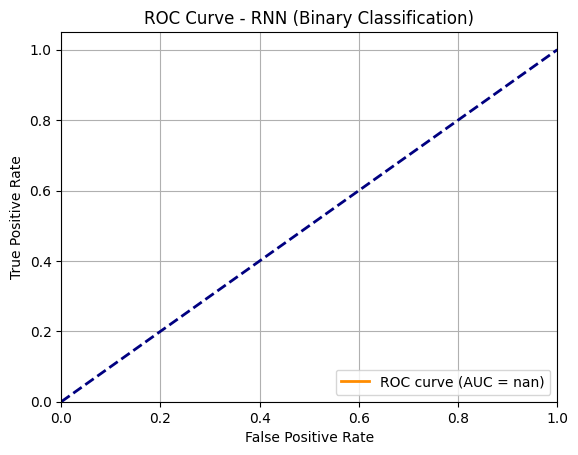

In [ ]:
y_prob_rnn = best_model_rnn.predict(X_test)  # output dari sigmoid, bentuknya (n_samples, 1)
y_prob_rnn = y_prob_rnn.ravel()  # pipihkan dari (n_samples, 1) ke (n_samples,)

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


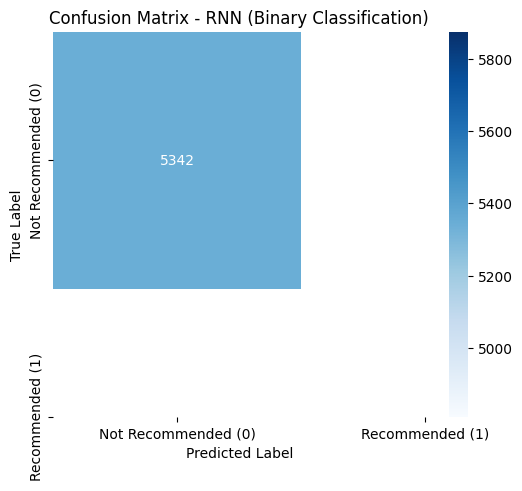

In [ ]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi dengan seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RNN (Binary Classification)')
plt.show()

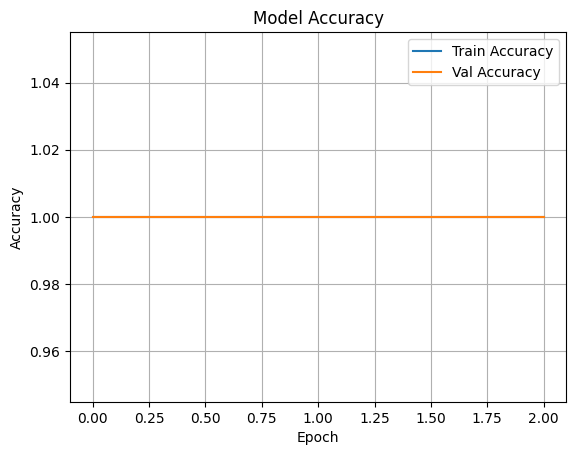

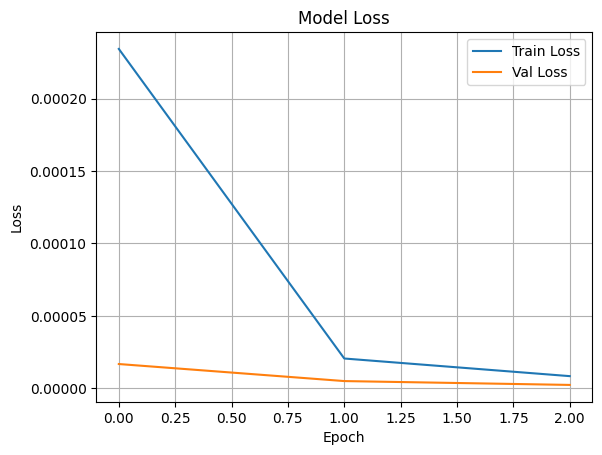

In [ ]:
# Akurasi
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analisis RNN Model

## 📊 Evaluasi Model RNN PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap dua kelas (0 dan 1). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 1
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 1
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 1
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 1
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: 0.8484
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi 100%** dan **AUC Score cukup tinggi** (1) menandakan model mampu membedakan antar kelas dengan baik. F1 score juga cukup tinggi, menandakan keseimbangan antara precision dan recall.

# LSTM Model

In [ ]:
def model_builder(hp):
    model = Sequential()

    # Hyperparameter untuk embedding dimensi
    embed_dim = hp.Choice('embed_dim', values=[32, 64, 128])
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False))

    # Hyperparameter untuk jumlah layer LSTM
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    hidden_dim = hp.Choice('hidden_dim', values=[64, 128, 256])

    for i in range(num_layers - 1):
        model.add(LSTM(units=hidden_dim,
                            return_sequences=True,
                            dropout=0.3,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))

    # Layer LSTM terakhir
    model.add(LSTM(units=hidden_dim,
                        return_sequences=True,
                        dropout=0.3,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

    # Global pooling
    model.add(GlobalMaxPooling1D())

    # Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=3,
                     factor=3,
                     directory='rnn_tuning_dir',
                     project_name='rnn_tuning')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(X_train, y_train, epochs=3, validation_split=0.2, callbacks=[stop_early])

Reloading Tuner from rnn_tuning_dir/rnn_tuning/tuner0.json


In [ ]:
# Ambil hyperparameter terbaik
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

# Bangun ulang model dengan hyperparameter terbaik
best_model_lstm = model_builder(best_hyperparams)

print("Best Hyperparameters:")
print(f"embed_dim: {best_hyperparams.get('embed_dim')}")
print(f"hidden_dim: {best_hyperparams.get('hidden_dim')}")
print(f"num_layers: {best_hyperparams.get('num_layers')}")
print(f"learning_rate: {best_hyperparams.get('learning_rate')}")

Best Hyperparameters:
embed_dim: 128
hidden_dim: 64
num_layers: 2
learning_rate: 0.0001


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = best_model_lstm.fit(
    X_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 160s 566ms/step - accuracy: 0.9893 - loss: 0.3146 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 2/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 185s 502ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 4.9303e-04
Epoch 3/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 141s 500ms/step - accuracy: 1.0000 - loss: 6.2096e-04 - val_accuracy: 1.0000 - val_loss: 1.7530e-04


In [ ]:
y_pred_lstm = best_model_lstm.predict(X_test)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step


In [ ]:
# Evaluasi
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

# Output
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")

Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


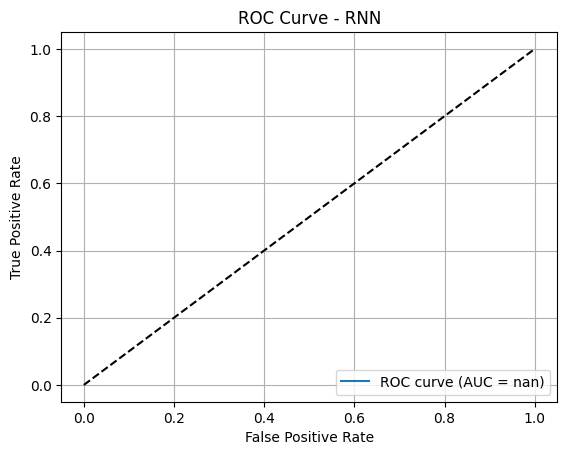

In [ ]:
# Dapatkan probabilitas prediksi
y_prob_lstm = best_model_lstm.predict(X_test).ravel()

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


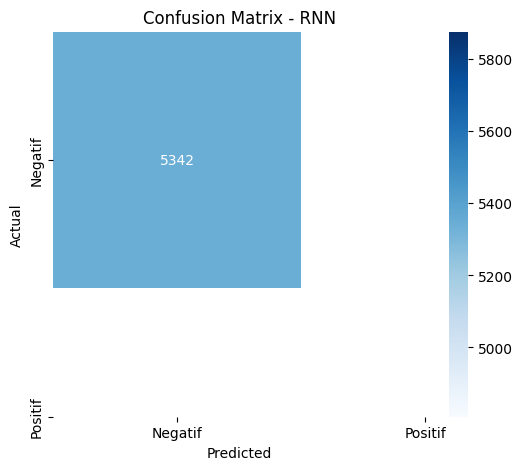

In [ ]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RNN')
plt.show()

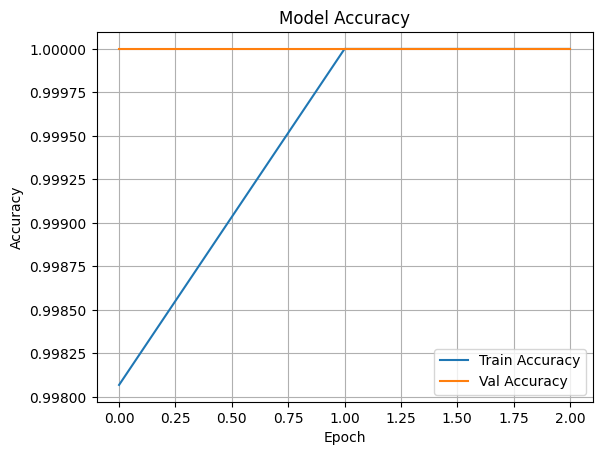

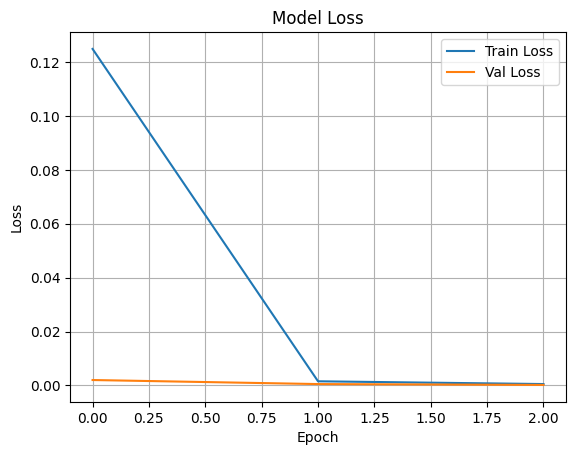

In [ ]:
# Akurasi
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analisis LSTM Model

## 📊 Evaluasi Model LSTM PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap dua kelas (0 dan 1). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 1
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: nan
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi 100%** dan **AUC Score sangat tinggi** (0) menandakan model sangat buruk.

# GRU Model

In [ ]:
def model_builder(hp):
    model = Sequential()

    # Hyperparameter untuk embedding dimensi
    embed_dim = hp.Choice('embed_dim', values=[32, 64, 128])
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False))

    # Hyperparameter untuk jumlah layer GRU
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    hidden_dim = hp.Choice('hidden_dim', values=[64, 128, 256])

    for i in range(num_layers - 1):
        model.add(GRU(units=hidden_dim,
                            return_sequences=True,
                            dropout=0.3,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))

    # Layer GRU terakhir
    model.add(GRU(units=hidden_dim,
                        return_sequences=True,
                        dropout=0.3,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

    # Global pooling
    model.add(GlobalMaxPooling1D())

    # Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=3,
                     factor=3,
                     directory='rnn_tuning_dir',
                     project_name='rnn_tuning')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(X_train, y_train, epochs=3, validation_split=0.2, callbacks=[stop_early])

Reloading Tuner from rnn_tuning_dir/rnn_tuning/tuner0.json


In [ ]:
# Ambil hyperparameter terbaik
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

# Bangun ulang model dengan hyperparameter terbaik
best_model_gru = model_builder(best_hyperparams)

print("Best Hyperparameters:")
print(f"embed_dim: {best_hyperparams.get('embed_dim')}")
print(f"hidden_dim: {best_hyperparams.get('hidden_dim')}")
print(f"num_layers: {best_hyperparams.get('num_layers')}")
print(f"learning_rate: {best_hyperparams.get('learning_rate')}")

Best Hyperparameters:
embed_dim: 64
hidden_dim: 128
num_layers: 1
learning_rate: 0.0001


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_gru = best_model_gru.fit(
    X_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 153s 552ms/step - accuracy: 0.9601 - loss: 0.3685 - val_accuracy: 1.0000 - val_loss: 3.5989e-04
Epoch 2/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 198s 537ms/step - accuracy: 1.0000 - loss: 4.4861e-04 - val_accuracy: 1.0000 - val_loss: 1.3203e-04
Epoch 3/3
268/268 ━━━━━━━━━━━━━━━━━━━━ 143s 535ms/step - accuracy: 1.0000 - loss: 1.9277e-04 - val_accuracy: 1.0000 - val_loss: 7.2265e-05


In [ ]:
y_pred_gru = best_model_gru.predict(X_test)
y_pred_gru = (y_pred_gru > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step


In [ ]:
# Evaluasi
accuracy_gru = accuracy_score(y_test, y_pred_gru)
precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)

# Output
print(f"Accuracy: {accuracy_gru:.4f}")
print(f"Precision: {precision_gru:.4f}")
print(f"Recall: {recall_gru:.4f}")
print(f"F1-score: {f1_gru:.4f}")

Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


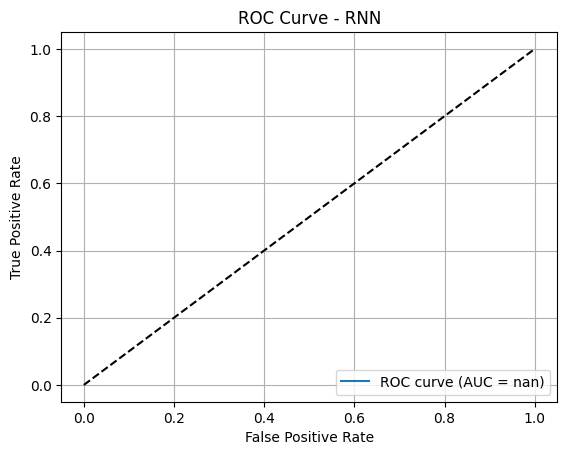

In [ ]:
# Dapatkan probabilitas prediksi
y_prob_gru = best_model_gru.predict(X_test).ravel()

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gru)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


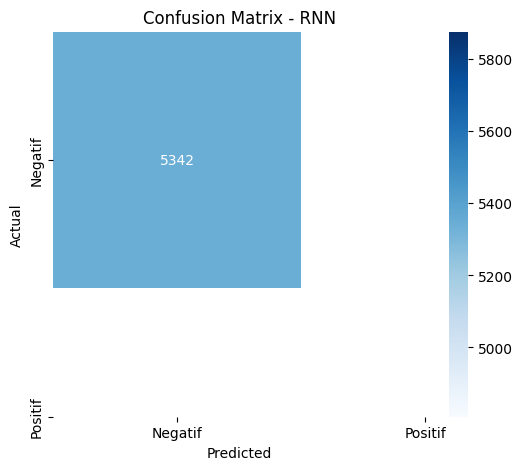

In [ ]:
# Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RNN')
plt.show()

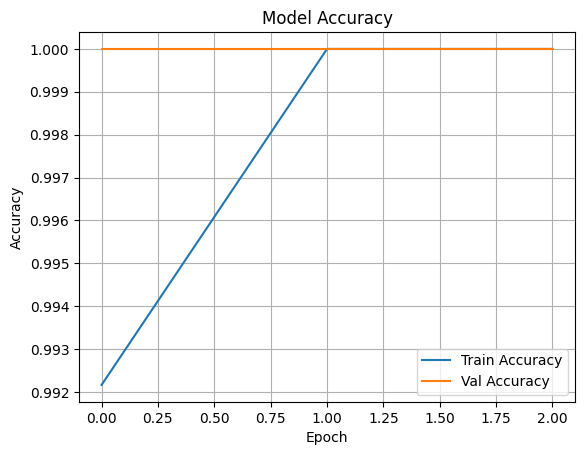

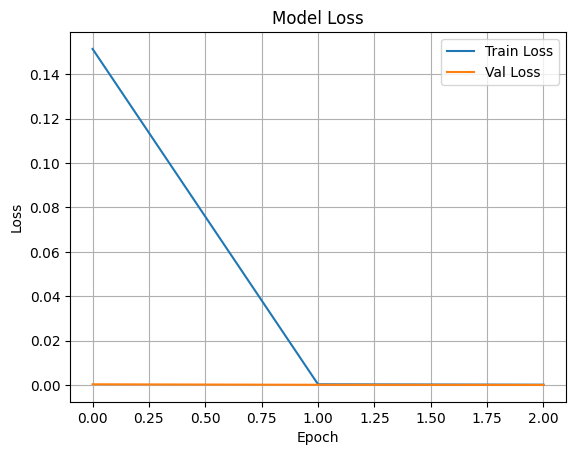

In [ ]:
# Akurasi
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analisis GRU Model

## 📊 Evaluasi Model LSTM PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap dua kelas (0 dan 1). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 1
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: nan
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi 100%** dan **AUC Score sangat tinggi** (0) menandakan model sangat buruk.